In [47]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
random.seed(123) 
np.random.seed(123) 

In [77]:
df=pd.read_csv("trainData.csv",engine="python", sep=",") 

## SMOTE


In [78]:

df.loc[df["Is.Fraudulent"]==1].shape[0]/df.shape[0]  # IsFraudulent ratio 

df.drop(columns=["Unnamed: 0"],inplace=True) 

df["Transaction.Date"] = pd.to_datetime(df["Transaction.Date"], format = "ISO8601")

df['Transaction.Date_Num'] = df['Transaction.Date'].map(pd.Timestamp.toordinal)

dfSamples=df.drop(columns=["Transaction.Date"],inplace=False).copy()


X = dfSamples.drop("Is.Fraudulent", axis=1)
y = dfSamples["Is.Fraudulent"]


Numeric=['Transaction.Date_Num','Transaction.Amount',"Customer.Age",'Account.Age.Days','Transaction.Hour','Quantity'] 
Categorical = [i for i in X.columns if i not in Numeric]

In [79]:
scaler = StandardScaler()
X[Numeric] = scaler.fit_transform(X[Numeric])


In [80]:
X = pd.get_dummies(X, columns=Categorical, drop_first=True)

In [81]:
smote = SMOTE(sampling_strategy=0.11, random_state=42,k_neighbors=5)
X,y=smote.fit_resample(X,y)

In [88]:
merged = pd.concat([X, y], axis=1, ignore_index=True)

#merged.to_csv("trainDataSMOTE.csv")

## MONTH DAY HOUR 

<Axes: xlabel='day', ylabel='Count'>

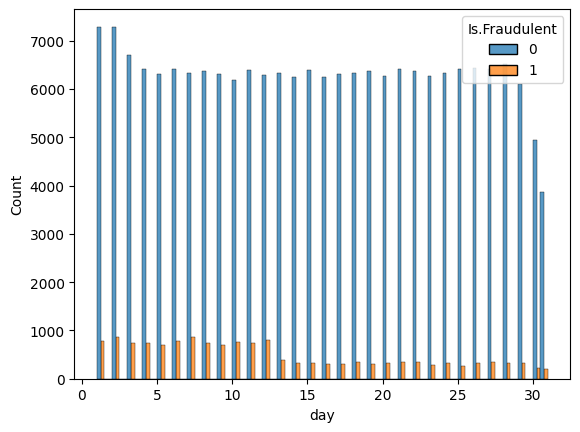

In [4]:
df["month"]=df["Transaction.Date"].apply(lambda x : float(x[5:7]) if x[5]!=0 else float(x[6:7]) )
df["day"]=df["Transaction.Date"].apply(lambda x : float(x[8:10]) if x[8]!=0 else float(x[9:10])) 
sns.histplot(df, x="day", hue="Is.Fraudulent", multiple="dodge") #seems in first part of months there are more frauds

In [5]:
maximalSplit=0
output=0
for i in range(1,31):
    df["partOfMonth"]=df["day"].apply(lambda x: "First" if x<=i else "Second") 
    temp1=df.loc[(df["partOfMonth"]=="First") & df["Is.Fraudulent"]==1].shape[0]/df.loc[(df["partOfMonth"]=="First")].shape[0] #fraud rate
    if temp1>maximalSplit: 
        maximalSplit=temp1 
        output=i
print(output,maximalSplit) # thus 12 best split

12 0.10511642786956422


In [6]:
df["partOfMonth"]=df["day"].apply(lambda x: "First" if x<=12 else "Second")

<Axes: xlabel='partOfMonth', ylabel='Count'>

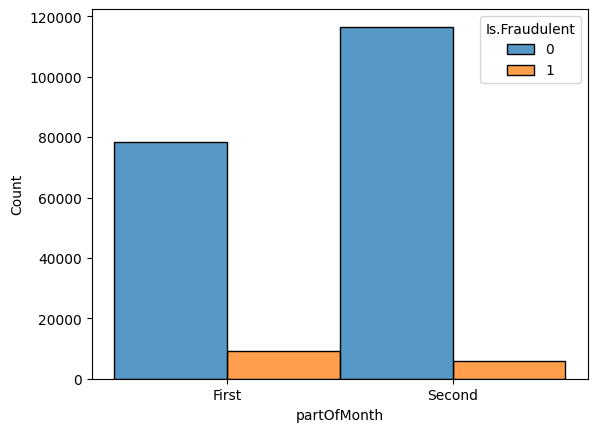

In [7]:
sns.histplot(data=df,x="partOfMonth",hue="Is.Fraudulent",multiple="dodge" ) 

In [8]:
# Convert Month to Sinusoidal Representation
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Convert Hour to Sinusoidal Representation
df["hour_sin"] = np.sin(2 * np.pi * df["Transaction.Hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["Transaction.Hour"] / 24)

df["hour_angle"] = np.arctan2(df["hour_sin"], df["hour_cos"])
df["month_angle"]=np.arctan2(df["month_sin"],df["month_cos"]) 

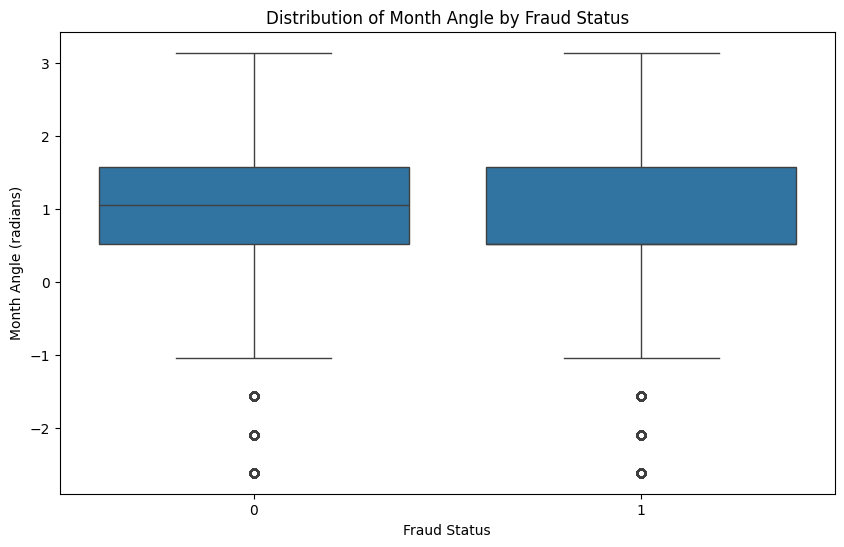

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Is.Fraudulent', y='month_angle')
plt.title('Distribution of Month Angle by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Month Angle (radians)')
plt.show()

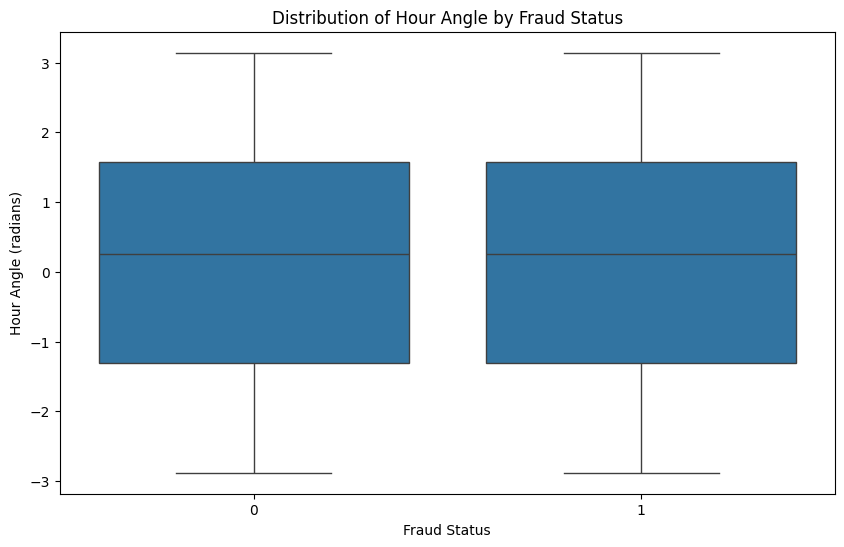

In [10]:
df.loc[:,["Transaction.Hour", "hour_angle"]].drop_duplicates().sort_values(by="Transaction.Hour").round(2)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Is.Fraudulent', y='hour_angle')
plt.title('Distribution of Hour Angle by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Hour Angle (radians)')
plt.show()

In [11]:
df.loc[:,["month", "month_angle"]].drop_duplicates().sort_values(by="month").round(2)

,month,month_angle
3,1.0,0.52
15,2.0,1.05
0,3.0,1.57
19,4.0,2.09
2,5.0,2.62
4,6.0,3.14
8,7.0,-2.62
1,8.0,-2.09
71,9.0,-1.57
7,10.0,-1.05


## MINOR

In [12]:
df["Is.Minor"]=df["Customer.Age"].apply(lambda x : True if x<18 else False) 
sum(df["Is.Fraudulent"])/df.shape[0] * 100 #percentage of minor

df.loc[(df["Is.Minor"] == 1) & (df["Is.Fraudulent"] == 1)].shape[0]/df.loc[df["Is.Minor"]==1].shape[0] #percentage of frauds in minors

0.05337255725992856

## HIGH AMOUNT

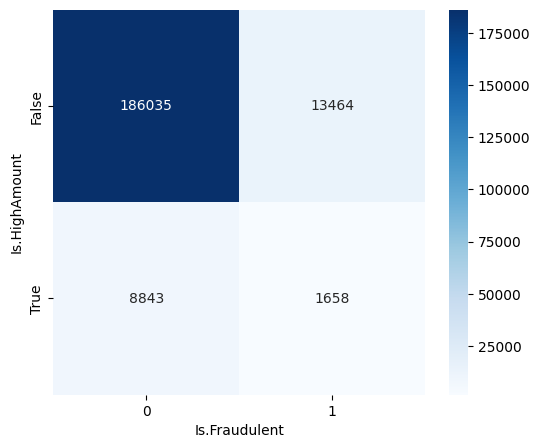

In [13]:
#NOTHING FANCY
HighAmountInt=df["Transaction.Amount"].quantile(0.95)
df["Is.HighAmount"]=df["Transaction.Amount"].apply(lambda x : True if x>=HighAmountInt else False) 

binary_crosstab = pd.crosstab(df["Is.HighAmount"], df["Is.Fraudulent"])

plt.figure(figsize=(6, 5))
sns.heatmap(binary_crosstab, annot=True, cmap="Blues", fmt="d")
plt.show()

## DAY OF THE WEEK

<Axes: xlabel='Transaction.Weekday', ylabel='Count'>

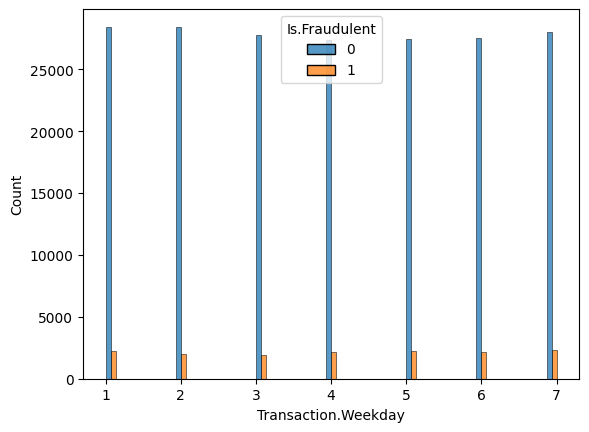

In [14]:
# DAY OF THE WEEK 
  # Ensure it's in datetime format
df["Transaction.Weekday"] = df["Transaction.Date"].dt.weekday + 1  # 1 = Monday, 7 = Sunday
sns.histplot(data=df,x="Transaction.Weekday",hue="Is.Fraudulent",multiple="dodge") 

In [15]:
#PERHAPS?
for i in range(1, 8): 
    fraud_count = df.loc[(df["Transaction.Weekday"] == i) & (df["Is.Fraudulent"] == 1)].shape[0]
    total_count = df.loc[df["Transaction.Weekday"] == i].shape[0]
    
    fraud_rate = fraud_count / total_count if total_count > 0 else 0  

    print(f"{i}-th day: {fraud_rate:.4f} fraud rate")

1-th day: 0.0740 fraud rate
2-th day: 0.0648 fraud rate
3-th day: 0.0658 fraud rate
4-th day: 0.0730 fraud rate
5-th day: 0.0764 fraud rate
6-th day: 0.0738 fraud rate
7-th day: 0.0763 fraud rate
